/home/gabriel/PycharmProjects/Sandpile/Code/analysis.py:87: RuntimeWarning: divide by zero encountered in power
  return np.exp(n.nominal_value) * x**m.nominal_value


,dimension,grid,relax,tau,alpha,lambda,gamma1,1/gamma1,gamma2,1/gamma2,gamma3,1/gamma3
0,2,40,op co,2.38+/-0.08,2.23+/-0.04,2.15+/-0.15,1.485+/-0.019,0.674+/-0.021,1.68+/-0.10,0.521+/-0.020,1.13+/-0.07,0.83+/-0.04


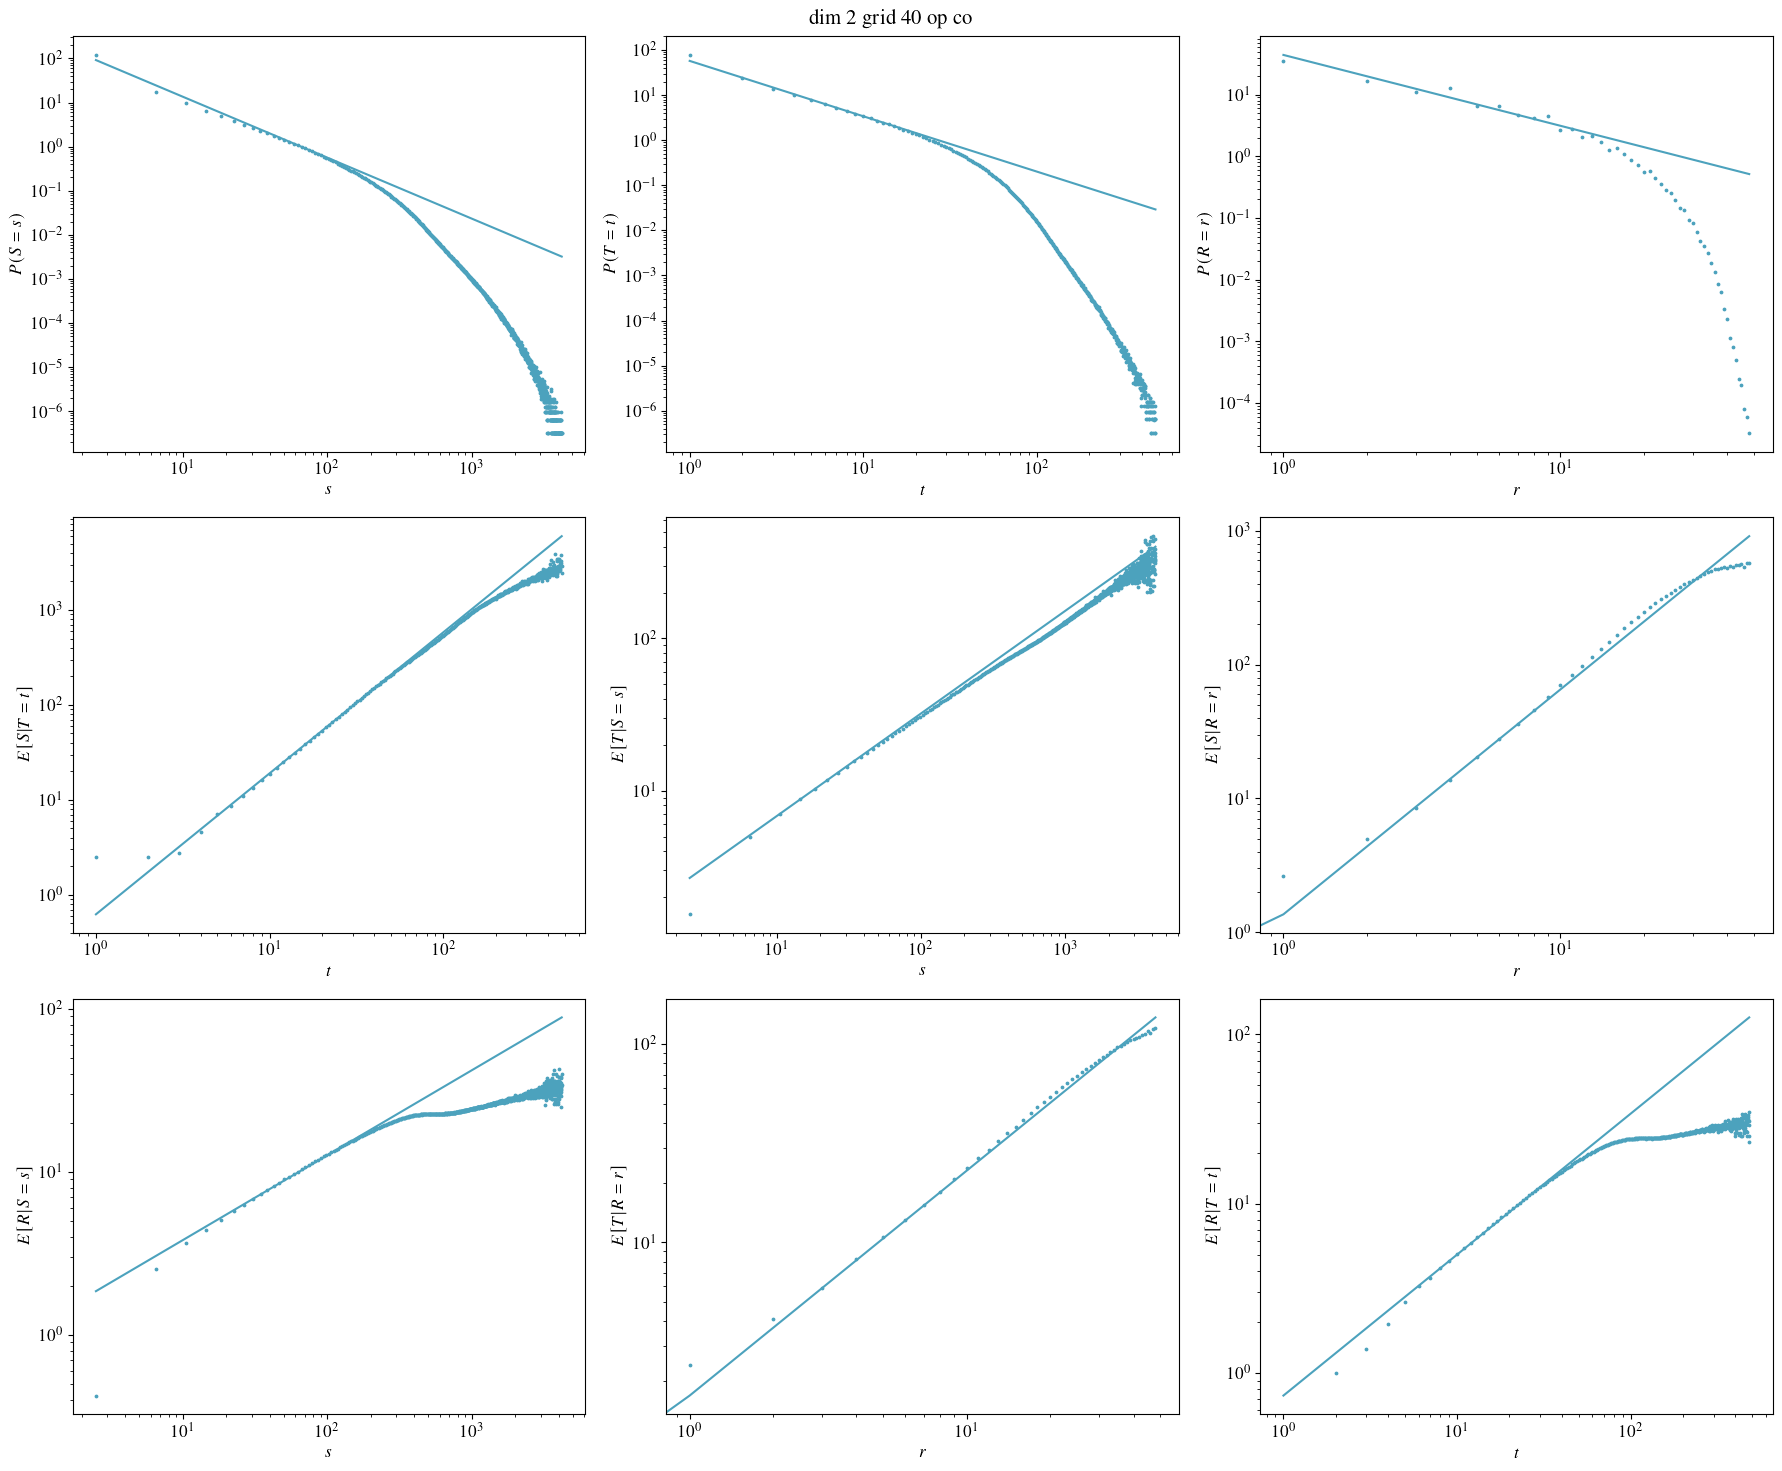

In [9]:
import matplotlib.pyplot as plt

from analysis import plot_scaling_exponents
from computation import *
import json
import pathlib
import pandas as pd

fig, ax = plt.subplots(3,3, figsize=(18, 15))
data_dir = pathlib.Path("data")
with open("scaling_exponents.json", "r") as f:
    meta = json.load(f)

# if specified, calculate scaling exponents for only one data set
do_plot = False
if isinstance(meta[0], int):
    meta = [meta[meta[0]]]
    do_plot = True

df = pd.DataFrame()
for m in meta:
    if not (data_dir / m["path"] / "avalanche_distribution.npz").exists():
        print(f"no avalanche distribution for {m['path']}")
        continue
    (s, t, r), bins = load_3d_dist(data_dir / m["path"] / "avalanche_distribution.npz")
    fig.suptitle(m["label"])
    _df = plot_scaling_exponents(s, t, r, bins, ax, pathlib.Path(m["path"]).name,
                                m.get("limits", None), do_plot)
    df = pd.concat([df, _df])
df

In [126]:
import uncertainties as unc
df.query("grid != 5 and relax == 'cl nco'", inplace=True)
df.drop("relax", axis=1, inplace=True)
# df = df.map(lambda x: "{:.2uS}".format(x) if isinstance(x, unc.core.AffineScalarFunc) else x)
df_new = df.sort_values(["dimension", "grid"])
# df_new.reset_index(level='relax', inplace=True)
# df_new.drop("relax", axis=0, inplace=True)
# df_new["relax"]
# df_new.drop("relax", inplace=True)
df_new


,dimension,grid,tau,alpha,lambda,gamma1,1/gamma1,gamma2,1/gamma2,gamma3,1/gamma3
0,1,40,1.03+/-0.10,0.0027+/-0.0008,0.089+/-0.006,1.34+/-0.05,0.87+/-0.04,1.32+/-0.06,1.17+/-0.09,0.817+/-0.021,1.234+/-0.024
0,2,10,2.037+/-0.022,1.937+/-0.033,1.7+/-0.4,1.471+/-0.006,0.6631+/-0.0020,1.55+/-0.08,0.687+/-0.020,0.93+/-0.07,0.96+/-0.04
0,2,20,2.0026+/-0.0033,1.924+/-0.012,1.5+/-0.4,1.491+/-0.005,0.6652+/-0.0013,1.64+/-0.06,0.585+/-0.004,1.07+/-0.04,1.01+/-0.05
0,2,40,2.046+/-0.018,1.972+/-0.007,1.73+/-0.05,1.5728+/-0.0014,0.6541+/-0.0013,1.84+/-0.04,0.5358+/-0.0026,1.167+/-0.009,0.857+/-0.007
0,3,10,2.499+/-0.006,2.557+/-0.024,2.32+/-0.31,1.5782+/-0.0031,0.647+/-0.004,1.81+/-0.12,0.498+/-0.006,1.22+/-0.04,0.747+/-0.015
0,3,20,2.384+/-0.006,2.452+/-0.015,2.22+/-0.17,1.6761+/-0.0029,0.6213+/-0.0034,1.80+/-0.12,0.476+/-0.007,1.22+/-0.05,0.753+/-0.010
0,4,15,2.633+/-0.006,2.579+/-0.032,2.77+/-0.13,1.716+/-0.004,0.5760+/-0.0017,2.13+/-0.11,0.398+/-0.005,1.34+/-0.04,0.621+/-0.005
0,5,10,2.662+/-0.011,2.61+/-0.05,2.32+/-0.17,1.661+/-0.004,0.5715+/-0.0013,2.26+/-0.10,0.407+/-0.004,1.41+/-0.04,0.600+/-0.007
0,6,10,2.961+/-0.018,2.84+/-0.04,2.37+/-0.18,1.695+/-0.004,0.5318+/-0.0029,2.39+/-0.08,0.353+/-0.008,1.46+/-0.04,0.626+/-0.011


In [127]:
df_table = df_new.map(lambda x: "{:.2uS}".format(x) if isinstance(x, unc.core.AffineScalarFunc) else x)
header = [
    "Dimension",
    "Grid",
    r"$\tau$",
    r"$\alpha$",
    r"$\lambda$",
    r"$\gamma_1$",
    r"$1/\gamma_1$",
    r"$\gamma_2$",
    r"$1/\gamma_2$",
    r"$\gamma_3$",
    r"$1/\gamma_3$",
]
df_table.to_latex(
    "tables/scaling_exponents_cl_nco.tex",
    index=False,
    escape=False,
    header=header,
    column_format=r"rr|ccccccccc",
)


In [128]:
df_comp = df_new.copy()

df_comp["1/gamma1 inv"] = 1 / df["1/gamma1"]
df_comp["1/gamma2 inv"] = 1 / df["1/gamma2"]
df_comp["1/gamma3 inv"] = 1 / df["1/gamma3"]
df_comp["gamma2_new"] = df["gamma1"] * df["gamma3"]
# df_comp["alpha_new"] = 2 + (df["lambda"] - 2) / df["gamma3"]
df_comp["lambda1"] = (df["alpha"] - 2)* df["gamma3"] + 2
df_comp["lambda2"] = (df["tau"] - 2)* df["gamma2"] + 2
# df_comp["tau_new"] = 2 + (df["lambda"] - 2) / df["gamma2"]
df_comp.drop(columns=["1/gamma1", "1/gamma2", "1/gamma3"], inplace=True)
df_comp = df_comp[
    [
        "dimension",
        "grid",
        "lambda",
        # "alpha",
        "lambda1",
        # "tau",
        "lambda2",
        "gamma1",
        "1/gamma1 inv",
        "gamma2",
        "1/gamma2 inv",
        "gamma2_new",
        "gamma3",
        "1/gamma3 inv",
    ]
]
header = [
    "Dimension",
    "Grid",
    # r"$\alpha$",
    # r"$2 + (\lambda - 2)/\gamma_3$",  # alpha_new
    # r"$\tau$",
    # r"$2 + (\lambda - 2)/\gamma_2$",  # tau_new
    r"$\lambda$",
    r"$(\alpha - 2)\gamma_2 + 2$",
    r"$(\tau - 2)\gamma_3 + 2$",
    r"$\gamma_1$",
    r"$(1/\gamma_1)^{{-1}}$",
    r"$\gamma_2$",
    r"$(1/\gamma_2)^{{-1}}$",
    r"$\gamma_1 \gamma_3$",
    r"$\gamma_3$",
    r"$(1/\gamma_3)^{{-1}}$",
]
df_comp = df_comp.map(lambda x: "{:.2uS}".format(x) if isinstance(x, unc.core.AffineScalarFunc) else x)
df_comp.to_latex(
    "tables/scaling_exponents_comparison_cl_nco.tex",
    header=header,
    index=False,
    escape=False,
    column_format=r"rr|ccccccccccc",
)
